In [1]:
import tensorflow as tf
from Poisson_CNN import *
from generate_cholesky_soln import generate_dataset
from generate_laplace_soln import generate_random_boundaries
import numpy as np
import matplotlib.pyplot as plt
tf.keras.backend.set_floatx('float32')

In [5]:
bc_nn_params = {'x_output_resolution' : 64}
mod = Poisson_CNN(n_quadpts = 27, bc_nn_parameters = bc_nn_params, mse_component_weight = 1e+1, homogeneous_poisson_nn_weights = 'Homogeneous_Poisson_NN_2.h5', bc_nn_weights = 'Dirichlet_BC_NN.h5', bc_nn_trainable=True, homogeneous_poisson_nn_trainable=True)
from IPython.display import clear_output
mod([tf.random.uniform((10,1,64,64), dtype = tf.keras.backend.floatx()), tf.random.uniform((10,1,64), dtype = tf.keras.backend.floatx()), tf.random.uniform((10,1,64), dtype = tf.keras.backend.floatx()), tf.random.uniform((10,1,64), dtype = tf.keras.backend.floatx()), tf.random.uniform((10,1,64), dtype = tf.keras.backend.floatx()), tf.random.uniform((10,1), dtype = tf.keras.backend.floatx())])
clear_output()
mod.load_weights('asd2.h5')

In [3]:
def dataset_generator():
    batch_size = 25
    while True:
        nx = np.random.randint(64,115)#64
        ny = np.random.randint(64,115)#64
        dx = 0.1*(np.random.rand() + 0.01)
        boundaries = generate_random_boundaries(nx, ny, batch_size=batch_size, return_with_expanded_dims=False)
        soln, rhs = generate_dataset(batch_size, [nx,ny], dx, boundaries=boundaries, initial_smoothness=np.random.randint(5,20))
        for key in boundaries.keys():
            boundaries[key] = tf.expand_dims(boundaries[key], axis = 1)
        yield (rhs, boundaries['left'], boundaries['top'], boundaries['right'], boundaries['bottom'], dx * tf.ones((batch_size,1), dtype = tf.keras.backend.floatx())), soln
        #yield (rhs, boundaries, dx * tf.ones((batch_size,1), dtype = tf.keras.backend.floatx())), soln

In [4]:
cb = [tf.keras.callbacks.ModelCheckpoint('asd2.h5', monitor='mse', verbose=1, save_best_only=True, save_weights_only=True), tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', min_lr = 1e-15, verbose = True, patience = 3)]
mod.compile(loss = mod.integral_loss, optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), metrics = ['mse', 'mae'])
mod.run_eagerly = True
mod.fit_generator(generator=dataset_generator(), steps_per_epoch=200, epochs=5000, validation_data=dataset_generator(), validation_steps=3, callbacks=cb)


Epoch 1/5000
199/200 [============================>.] - ETA: 4s - loss: 1.0384 - mse: 0.0432 - mae: 0.1440
Epoch 00001: mse improved from inf to 0.03239, saving model to asd2.h5
200/200 [==============================] - 813s 4s/step - loss: 1.0382 - mse: 0.0431 - mae: 0.1437 - val_loss: 0.7858 - val_mse: 0.0141 - val_mae: 0.0784
Epoch 2/5000
199/200 [============================>.] - ETA: 3s - loss: 0.6338 - mse: 0.0152 - mae: 0.0814
Epoch 00002: mse improved from 0.03239 to 0.01568, saving model to asd2.h5
200/200 [==============================] - 800s 4s/step - loss: 0.6382 - mse: 0.0152 - mae: 0.0814 - val_loss: 0.3279 - val_mse: 0.0072 - val_mae: 0.0540
Epoch 3/5000
199/200 [============================>.] - ETA: 4s - loss: 1.0783 - mse: 0.0322 - mae: 0.1141
Epoch 00003: mse did not improve from 0.01568
200/200 [==============================] - 808s 4s/step - loss: 1.0754 - mse: 0.0322 - mae: 0.1142 - val_loss: 0.5630 - val_mse: 0.0175 - val_mae: 0.0964
Epoch 4/5000
199/200 [===

E0508 17:24:42.691514 140107913774912 ultratb.py:149] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ago14/.conda/envs/tf-nightly/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-8fa2eba7c086>", line 4, in <module>
    mod.fit_generator(generator=dataset_generator(), steps_per_epoch=200, epochs=5000, validation_data=dataset_generator(), validation_steps=3, callbacks=cb)
  File "/home/ago14/.conda/envs/tf-nightly/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py", line 1515, in fit_generator
    steps_name='steps_per_epoch')
  File "/home/ago14/.conda/envs/tf-nightly/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_generator.py", line 257, in model_iteration
    batch_outs = batch_function(*batch_data)
  File "/home/ago14/.conda/envs/tf-nightly/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py", line 1247, in train_on_batch
    output_loss_metrics=self._output_los

KeyboardInterrupt: 

In [38]:
i = dataset_generator()
inp, soln = next(i)

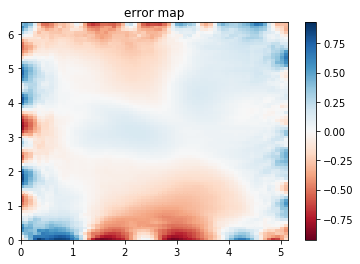

In [46]:
x, y = np.meshgrid(np.linspace(0, soln.shape[-2]*inp[-1][0,0], soln.shape[-2]), np.linspace(0, soln.shape[-1]*inp[-1][0,0], soln.shape[-1]), indexing = 'ij')
#p_r = np.random.randint(0,soln.shape[0])
#z = soln[p_r,0,...]
z = mod(inp)[p_r,0,...]
#z = tf.cast(mod(inp)[p_r,0,...], tf.float64)-soln[p_r,0,...]
#z = tf.divide(tf.cast(mod(inp)[p_r,0,...], tf.float64)-soln[p_r,0,...], soln[p_r,0,...])
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('error map')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

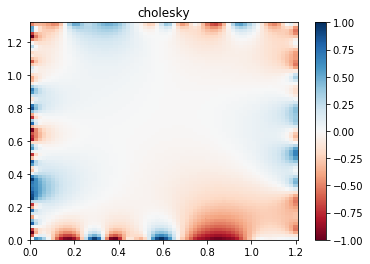

In [29]:
x, y = np.meshgrid(np.linspace(0, soln.shape[-2]*inp[-1][0,0], soln.shape[-2]), np.linspace(0, soln.shape[-1]*inp[-1][0,0], soln.shape[-1]), indexing = 'ij')
#p_r = np.random.randint(0,soln.shape[0])
z = soln[p_r,0,...]
#z = mod(inp)[p_r,0,...]
#z = mod([tf.expand_dims(b['left'], axis = 1), dx * tf.ones((soln.shape[0],1), dtype = 'float64')])[p_r,0,...]
#z = mod(tf.expand_dims(b['left'], axis = 1))[p_r,0,...]
#z = tf.divide(mod([tf.expand_dims(b['left'], axis = 1), dx * tf.ones((soln.shape[0],1), dtype = 'float64')])[p_r,0,...]-soln[p_r,0,...], soln[p_r,0,...])
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('cholesky')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [2]:
dbnn = Dirichlet_BC_NN_2B(data_format = 'channels_first', mse_component_weight = 1e+1, x_output_resolution = 64)
from generate_laplace_soln import generate_laplace_soln
def dbnn_dataset_generator():
    while True:
        nx = 64#np.random.randint(64,128)
        ny = 64#np.random.randint(64,128)
        boundaries, soln, dx = generate_laplace_soln(batch_size=75, nonzero_boundaries=['left'], smoothness=np.random.randint(5,20), nx = nx, ny = ny)
        #print(boundaries)
        yield [boundaries['left'], dx * tf.ones((soln.shape[0],1), dtype = 'float64')], soln
s = dbnn_dataset_generator()
inp,soln = next(s)
dbnn(inp)
dbnn.load_weights('Dirichlet_BC_NN.h5')
from IPython.display import clear_output
clear_output()

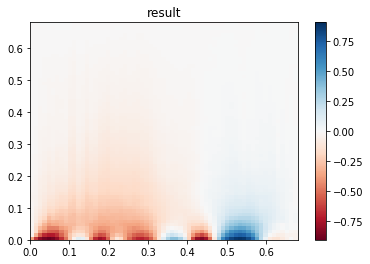

In [9]:
x, y = np.meshgrid(np.linspace(0, soln.shape[-2]*inp[-1][0,0], soln.shape[-2]), np.linspace(0, soln.shape[-1]*inp[-1][0,0], soln.shape[-1]), indexing = 'ij')
#p_r = np.random.randint(0,soln.shape[0])
#z = soln[p_r,0,...]
from Poisson_CNN import channels_first_rot90, channels_first_flip_left_right, channels_first_flip_up_down
z = channels_first_flip_up_down(channels_first_rot90(dbnn(inp), k = 3))[p_r,0,...]
#z = mod([tf.expand_dims(b['left'], axis = 1), dx * tf.ones((soln.shape[0],1), dtype = 'float64')])[p_r,0,...]
#z = mod(tf.expand_dims(b['left'], axis = 1))[p_r,0,...]
#z = tf.divide(mod([tf.expand_dims(b['left'], axis = 1), dx * tf.ones((soln.shape[0],1), dtype = 'float64')])[p_r,0,...]-soln[p_r,0,...], soln[p_r,0,...])
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('result')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [5]:
mod.save_weights('asd.h5')